In [1]:
%load_ext autoreload
%autoreload 2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import argparse
import repackage

import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [2]:
from experiment_utils import set_env, seed_everything
set_env()
from cgn_extensions.mnists.dataloaders import get_dataloaders

# Train concept classifier for double-colored-MNIST
We need to train:
1. A CF for classifying the digit's color
2. A CF for classifying the digit's shape
3. A CF for background color

## Load dataset

In [3]:
dl_train, dl_test = get_dataloaders('double_colored_MNIST', batch_size=1000, workers=4)

### Dataset size

In [4]:
print(f"Train: {dl_train.dataset.labels.shape[0]}")
print(f"Test: {dl_test.dataset.labels.shape[0]}")

Train: 50000
Test: 10000


### Get a sample image

In [5]:
random_idx = np.random.randint(0, dl_train.dataset.labels.shape[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


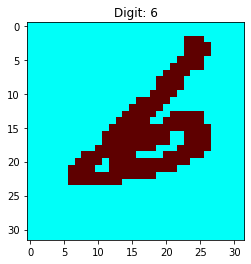

BG label: tensor([8])
Texture label: tensor([3])


In [6]:
plt.imshow(dl_train.dataset.__getitem__(random_idx)['ims'].transpose(0,1).transpose(1,2))
label = dl_train.dataset.__getitem__(random_idx)['labels']
plt.title(f"Digit: {label}")
plt.show()
print(f"BG label: {dl_train.dataset.__getitem__(random_idx)['bg_labels']}")
print(f"Texture label: {dl_train.dataset.__getitem__(random_idx)['texture_labels']}")

## Train color CF

In [21]:
from cgn_extensions.mnists.models.mnist_color_cf import train, test, MNIST_COLOR_CNN

# Args for training
args = argparse.Namespace()
args.batch_size = 512
args.epochs = 3
args.lr = 0.1
args.log_interval = 10
args.dataset = 'double_colored_MNIST'

# Data
dl_train, dl_test = get_dataloaders(args.dataset, batch_size=args.batch_size, workers=4)

# Model
model = MNIST_COLOR_CNN(num_classes=10)

# Optimizer
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
scheduler = StepLR(optimizer, step_size=2, gamma=0.7) 

# push to device and train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
device

device(type='cpu')

In [22]:
train_accs = dict()
test_accs = dict()
for epoch in range(1, args.epochs + 1):
    train_acc = train(args, model, device, dl_train, optimizer, epoch, 'texture') #max_batches=1000)
    test_acc = test(model, device, dl_test, 'texture')
    train_accs[epoch] = train_acc
    test_accs[epoch] = test_acc
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.291830
Train Epoch: 1 [5120/50000 (10%)]	Loss: 2.177366
Train Epoch: 1 [10240/50000 (20%)]	Loss: 2.107995
Train Epoch: 1 [15360/50000 (31%)]	Loss: 1.977944
Train Epoch: 1 [20480/50000 (41%)]	Loss: 1.799536
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.569085
Train Epoch: 1 [30720/50000 (61%)]	Loss: 1.383722
Train Epoch: 1 [35840/50000 (71%)]	Loss: 1.142452
Train Epoch: 1 [40960/50000 (82%)]	Loss: 0.928131
Train Epoch: 1 [46080/50000 (92%)]	Loss: 0.767545

Train set: Average loss: 0.6971, Accuracy: 28208/50000 (56.4%)


Test set: Average loss: 0.6533, Accuracy: 9296/10000 (92.960%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.695524
Train Epoch: 2 [5120/50000 (10%)]	Loss: 0.536064
Train Epoch: 2 [10240/50000 (20%)]	Loss: 0.437335
Train Epoch: 2 [15360/50000 (31%)]	Loss: 0.403606
Train Epoch: 2 [20480/50000 (41%)]	Loss: 0.344089
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.275156
Train Epoch: 2 [30720/50000 (61%)]	Loss: 0.264439
Train Epoch: 2 [35840/50000 (71%

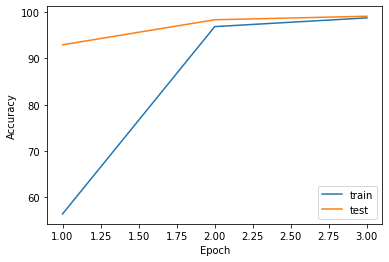

In [23]:
# Plot losses
plt.plot(train_accs.keys(), train_accs.values())
plt.plot(test_accs.keys(), test_accs.values())
plt.legend(['train', 'test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

### GradCam

In [69]:
# Target layer for Grad-CAM
target_layers = [model.model[3]]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available())

# Get a random batch
dl_train, dl_test = get_dataloaders('double_colored_MNIST', batch_size=10, workers=4)
gradcam_data = next(iter(dl_train))
input_tensor = gradcam_data['ims'][0].unsqueeze(0).clip(min=0, max=1).to(device)
grayscale_cam = cam(input_tensor=input_tensor, aug_smooth=True)
grayscale_cam = grayscale_cam[0, :]

rgb_img = input_tensor.squeeze(0).transpose(0,1).transpose(1,2).to('cpu').detach().numpy()
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=False)

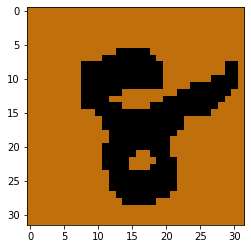

In [70]:
plt.imshow(rgb_img)

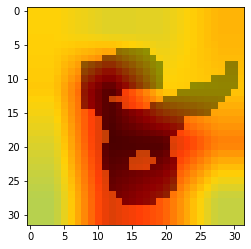

In [71]:
plt.imshow(visualization)

### Save the model

In [ ]:
# # save the model
# dataset_suffix = (args.dataset) if not args.combined else (args.dataset + "_combined")
# dataset_suffix += "_seed_" + str(args.seed) if args.seed is not None else ""
# save_path = f'mnists/experiments/classifier_{dataset_suffix}/weights/ckp_epoch_{args.epochs}.pth'
# os.makedirs(os.path.dirname(save_path), exist_ok=True)
# print('Saving model to {}'.format(save_path))
# torch.save(model.state_dict(), save_path)

### Make some predictions

## Train shape CF

## Train background CF